# supernode-features

The procedure of collecting and engineering topology-based supernode features for subsequent clustering.

__This is an older implementation containing attempts on the Multi-scale Betweenness Centrality.__

__Warning!__ Multiprocessing (16 cores), shortest paths (5 GB RAM).

Requires:

1. `data/supernodes/edges_pspace.json`
2. `data/preprocessed/routes.json`
3. `data/temp/subway_edges_pspace.json`

Produces:
1. `data/features/supernode_features.json`

In [1]:
import sys
sys.path.append('..')

In [2]:
from itertools import product
from multiprocessing import Pool
from typing import Dict

import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt

from myutils.json import load_json, save_json
from myutils.stats import corrcoef

from config import edges_pspace_fpath, routes_fpath, subway_edges_pspace_fpath, \
    supernode_features_fpath

plt.style.use('seaborn-whitegrid')

In [3]:
edges = load_json(edges_pspace_fpath)

edges[:5]

[{'u': 0, 'v': 6, 'w': 23.28185292299166, 'route': 10003},
 {'u': 0, 'v': 8, 'w': 14.863275410682126, 'route': 2871},
 {'u': 0, 'v': 9, 'w': 13.995378725186596, 'route': 2871},
 {'u': 0, 'v': 13, 'w': 10.92823404394134, 'route': 1135},
 {'u': 0, 'v': 14, 'w': 12.609849731838038, 'route': 1085}]

In [4]:
pspace = nx.Graph()

for edge in edges:
    pspace.add_edge(edge['u'], edge['v'], weight=edge['w'], route=edge['route'])

len(pspace), len(pspace.edges)

(3202, 118449)

In [5]:
routes = pd.read_json(routes_fpath).set_index('id')

routes.head(2)

,name,type,direction,stops,distance,supernodes
id,,,,,,
1125,А,tram,1,"[16396, 16367, 16371, 16398, 16400, 16401, 164...",5.008430,"[620, 827, 828, 20, 309, 80, 310, 204, 5, 29, ..."
11125,А,tram,2,"[33093, 16348, 16350, 16354, 16357, 16346, 163...",3.826103,"[30, 829, 830, 621, 311, 831, 14, 81, 620]"


In [6]:
partial_routes = {
    (u, v, i): route[j : k + 1]
    for i, route in routes['supernodes'].iteritems()
    for j, u in enumerate(route)
    for k, v in enumerate(route)
    if j < k
}

In [7]:
subway_edges = load_json(subway_edges_pspace_fpath)

subway_edges[:5]

[{'u': 0, 'v': 6, 'w': 23.28185292299166, 'route': 10003},
 {'u': 0, 'v': 21, 'w': 13.125935702576376, 'route': 2},
 {'u': 0, 'v': 26, 'w': 9.416624034578554, 'route': 10003},
 {'u': 0, 'v': 37, 'w': 17.296068674283276, 'route': 2},
 {'u': 0, 'v': 40, 'w': 8.47553615930307, 'route': 2}]

In [8]:
subway_pspace = nx.Graph()

for edge in subway_edges:
    subway_pspace.add_edge(edge['u'], edge['v'], weight=edge['w'], route=edge['route'])

len(subway_pspace), len(subway_pspace.edges)

(65, 506)

## Standard features

<AxesSubplot:>

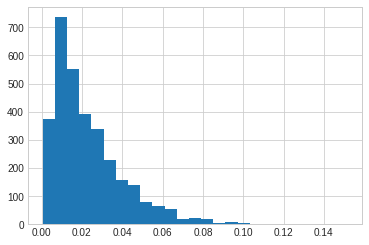

In [9]:
degree_centrality = pd.Series(nx.degree_centrality(pspace))

degree_centrality.hist(bins=25)

In [10]:
def chunks(l, n):
    return [tuple(l[i : i + n]) for i in range(0, len(l), n)]

In [11]:
def betweenness_centrality_parallel(G, processes=16):
    p = Pool(processes=processes)
    
    node_divisor = len(p._pool) * 4
    node_chunks = chunks(list(G.nodes()), int(G.order() / node_divisor))
    num_chunks = len(node_chunks)
    
    betweenness_centrality_chunks = p.starmap(
        nx.betweenness_centrality_subset,
        zip(
            [G] * num_chunks,
            node_chunks,
            [list(G)] * num_chunks,
            [True] * num_chunks,
            ['weight'] * num_chunks,
        ),
    )
    
    betweenness_centrality = betweenness_centrality_chunks[0]
    
    for betweenness_centrality_chunk in betweenness_centrality_chunks[1:]:
        for n in betweenness_centrality_chunk:
            betweenness_centrality[n] += betweenness_centrality_chunk[n]
        
    p.close()

    return betweenness_centrality

CPU times: user 3.29 s, sys: 287 ms, total: 3.58 s
Wall time: 43.8 s


<AxesSubplot:>

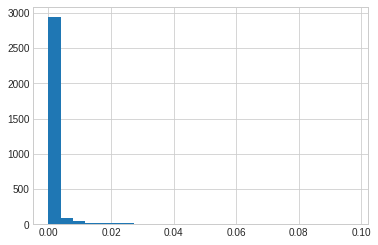

In [12]:
%%time

betweenness_centrality = pd.Series(betweenness_centrality_parallel(pspace))

betweenness_centrality.hist(bins=25)

In [13]:
def single_source_dijkstra_path_length_subset(g, subset):
    return {
        node: dict(nx.single_source_dijkstra_path_length(pspace, node, weight='weight'))
        for node in subset
    }

In [14]:
def shortest_path_lengths_parallel(G, processes=16):
    p = Pool(processes=processes)
    
    node_divisor = len(p._pool) * 4
    node_chunks = chunks(list(G.nodes()), int(G.order() / node_divisor))
    num_chunks = len(node_chunks)
    
    shortest_path_lengths_chunks = p.starmap(
        single_source_dijkstra_path_length_subset,
        zip(
            [G] * num_chunks,
            node_chunks,
        ),
    )
    
    shortest_path_lengths = shortest_path_lengths_chunks[0]
    
    for shortest_path_lengths_chunk in shortest_path_lengths_chunks[1:]:
        shortest_path_lengths.update(shortest_path_lengths_chunk)
        
    p.close()

    return shortest_path_lengths

In [15]:
%%time

shortest_path_lengths = pd.DataFrame(shortest_path_lengths_parallel(pspace))

shortest_path_lengths.head(2)

CPU times: user 5.05 s, sys: 1 s, total: 6.05 s
Wall time: 34 s


,0,6,8,9,13,14,15,16,19,21,...,2916,2917,2033,2034,2035,2036,2037,2038,3090,3091
0,0.000000,23.069443,13.624203,13.347050,6.194128,11.546631,7.649407,7.163426,2.690249,13.125936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269,0.461312,23.530756,14.085515,13.808362,6.655440,12.007943,7.209116,7.624739,3.144753,13.587248,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
def closeness_centrality(shortest_path_lengths: pd.DataFrame) -> pd.Series:
    N = shortest_path_lengths.shape[0]
    n = shortest_path_lengths.notna().sum(axis=0)
    
    d = shortest_path_lengths.sum(axis=0)
    d[d == 0] = 1
    
    return (n - 1) ** 2 / ((N - 1) * d)

<AxesSubplot:>

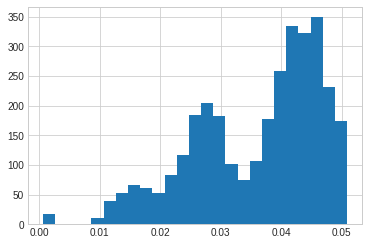

In [17]:
closeness_centrality = closeness_centrality(shortest_path_lengths.T)

closeness_centrality.hist(bins=25)

## Multiscale Betweenness Centrality

In [18]:
features = pd.DataFrame({
    'betweenness_centrality': betweenness_centrality,
    'closeness_centrality': closeness_centrality,
    'degree_centrality': degree_centrality,
    # 'multiscale_betweenness_centrality': mbc,
    # 'clustering': clustering,
    # 'eigenvector_centrality': eigenvector_centrality,
})

features.index.name = 'id'

features.head(2)

,betweenness_centrality,closeness_centrality,degree_centrality
id,,,
0,0.070812,0.046982,0.124024
1,0.087949,0.049458,0.078101


In [19]:
features.isna().any().any()

False

In [21]:
for col in list(features.columns):
    values = features[col]
    
    neighbour_mean = {}
    
    for node in pspace:
        # neighbours = set(pspace.successors(node)).union(set(pspace.predecessors(node)))
        neighbours = set(pspace.neighbors(node))
        mean = values[neighbours].mean()
        neighbour_mean[node] = mean
    
    neighbour_mean = pd.Series(neighbour_mean)    
    neighbour_mean.index.name = 'id'
    
    features[col + '_neighbour_mean'] = neighbour_mean
    
features.isna().any().any()

False

<AxesSubplot:>

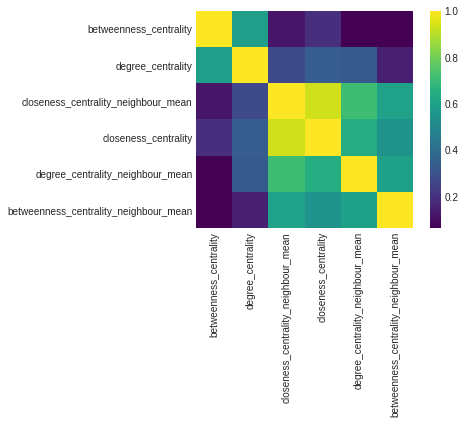

In [22]:
corr = corrcoef(features, method='spearman').fillna(0)

sns.heatmap(corr, square=True, cmap='viridis')

In [23]:
features_json = []

for i, row in features[sorted(features.columns)].iterrows():
    item = {'id': i}
    item.update(row.to_dict())
    
    features_json.append(item)
    
features_json[0]

{'id': 0,
 'betweenness_centrality': 0.0708123710928476,
 'betweenness_centrality_neighbour_mean': 0.0047093065785512485,
 'closeness_centrality': 0.046981632619449105,
 'closeness_centrality_neighbour_mean': 0.042130804264725125,
 'degree_centrality': 0.1240237425804436,
 'degree_centrality_neighbour_mean': 0.03709010959264146}

In [ ]:
save_json(features_json, supernode_features_fpath)